# Rating Curve Regression Calculator


## Modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.cm as cm
from pylab import rcParams

import scipy
import scipy.stats as sp
import scipy.optimize as op
from scipy.stats import linregress
from scipy.optimize import curve_fit

import statsmodels.api as sm

from datetime import datetime, date, timedelta

import wellapplication as wa

import platform
import sys
import glob
import os

import pyfinance

rcParams['figure.figsize'] = 15, 10
rcParams['legend.numpoints'] = 1

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ImportError: No module named 'options'

In [2]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
print("Scipy Version " +str(scipy.__version__))

Operating System Windows 7
Python Version 3.5.3 |Continuum Analytics, Inc.| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]
Pandas Version 0.20.1
Numpy Version 1.11.2
Matplotlib Version 1.5.3
Scipy Version 0.18.1


## Directories

In [3]:
if platform.system() == 'Windows':
    if platform.system() + " " + platform.release() == 'Windows 7':
        drive = 'M:/PROJECTS/Ogden Valley/stream flows/transducer data/'
    else:
        drive = 'E:/PROJECTS/Ogden Valley/stream flows/transducer data/'
else:
    drive = '/media/pi/Transcend/PROJECTS/Ogden Valley/stream flows/transducer data/'
    
#fileplace =  drive + '/PROJECTS/Round_Valley/'

#fileLocation = fileplace + 'URVH/URVH/'

xleplace = drive + 'xle_files/'

figplace = drive + 'hydrographs/'
print(drive)

M:/PROJECTS/Ogden Valley/stream flows/transducer data/


In [4]:
drive = "U:/GWP/Ogden Valley/stream flows/"
xleplace = drive + 'transducer data/xle_files/' 
figplace = drive + 'transducer data/hydrographs/'

## Functions

This notebook is used to create rating curves. 
The analysis follows Herschy 2009.
A power low regression is used of the form $$Q = C(h + a)^{n}$$
where $Q$ is discharge, $h$ is stage (in this case 'water surface elevation'), and $a$ is the effective depth of zero flow
<br>
http://www.ing.unitn.it/dica/tools/download/Quaderni/Foralps_TR_11.pdf

In [5]:
def crosscorr(datax, datay, lag=0):
    ''' 
    http://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
    Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    '''
    return datax.corr(datay.shift(lag))

def esRLM(x0,y):
    xa = sm.add_constant(x0)
    est = sm.RLM(y, xa).fit()
    r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
    slope = est.params[1]
    const = est.params[0]    
    return slope,const,r2

def scatterColor(x0,y,w):
    '''
    creates scatter plot with points colored by variable w
    all input arrays must have matching lengths
    
    returns slope and intercept of best fit line
    
    x0 = array of x values
    y = array of y values
    w = array of scalar values
    '''
    cmap = plt.cm.get_cmap('RdYlBu')
    norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array(w)
    sc = plt.scatter(x0, y, label='', color = m.to_rgba(w))

    #x0, y2, const, slope, x_prime, y_hat = RLM(x,y)

    xa = sm.add_constant(x0)

    est = sm.RLM(y, xa).fit()
    r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
    slope = est.params[1]

    x_prime = np.linspace(np.min(x0),np.max(x0),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)

    const = est.params[0]
    y2 = [i*slope + const for i in x0]

    plt.xlabel('Barometric Pressure (ft water)')
    plt.ylabel('Transducer Pressure (ft water)')
    lin = linregress(x0,y)
    x1 = np.arange(np.min(x0), np.max(x0),0.1)
    y1 = [i*lin[0]+lin[1] for i in x1]
    y2 = [i*slope+const for i in x1]
    plt.plot(x1,y1,c='g',label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(lin[0],lin[1],lin[2]**2))
    plt.plot(x1,y2,c='r',label='rlm regression m = {:.2f} b = {:.0f}, r2 = {:.2f}'.format(slope,const,r2))
    plt.legend()
    cbar = plt.colorbar(m)

    cbar.set_label('Julian Date')

    return slope,const



In [6]:
rcParams['figure.figsize'] = 15, 15

# UGS Data

Upload xle files, remove jumps, and trim ends where datalogger was out of water.  Combine into single sheet.

In [7]:
names = ['MiddleFork','N.BranchS.Fork','NorthFork','S.BranchS.Fork','SpringCreek'] #Strings in file names

dfs={}
df= {}

pdf = PdfPages(figplace+'individual_file_levels.pdf')


for name in names:
    plt.figure()
    df[name] = {}
    pth = xleplace+name+'*.xle'

    filelist = glob.glob(pth) # select all files with name string

    for i in range(len(filelist)): #iterate through all files with same name (should have different dates)
            print(name+'_'+str(i))
            df[name+'_'+str(i)+'_raw'] = wa.new_xle_imp(filelist[i]) #import
            df[name+'_'+str(i)] = wa.dataendclean(df[name+'_'+str(i)+'_raw'],'Level') #clean ends
            
            df[name+'_'+str(i)] = wa.jumpfix(df[name+'_'+str(i)],'Level',1.0)['Level'].to_frame()
            df[name+'_'+str(i)]['Level'] = df[name+'_'+str(i)]['Level'].apply(lambda x: x - df[name+'_'+str(i)]['Level'].mean())            
            df[name+'_'+str(i)] = wa.hourly_resample(df[name+'_'+str(i)],bse=0,minutes=30) #resample to match times
            plt.plot(df[name+'_'+str(i)].index,df[name+'_'+str(i)]['Level'],label = name+'_'+str(i))
            df[name+'_'+str(i)] = df[name+'_'+str(i)]['Level'].to_frame()
    dfs[name] = pd.concat([df[name+'_'+str(i)] for i in range(len(filelist))],axis=0) #combine all files of the same name

    dfs[name].sort_index(inplace=True) #sort to make in chronological order
    dfs[name] = dfs[name].groupby(level=0).first()#.to_frame() #remove duplicate datetime index values
    print(name)
    #dfs[name] = wa.jumpfix(dfs[name],'Level',0.2)['Level'] #remove jumps from moving the transducer
    dfs[name].dropna(inplace=True) #drop null values
    plt.title(name)
    plt.legend()
    plt.tight_layout()
    pdf.savefig()
    plt.close()
pdf.close()
d = pd.concat([dfs[name] for name in names], axis=1, keys=names) #combine all the data

MiddleFork_0
Dropped from beginning to 2015-09-09 16:09:24
MiddleFork_1
MiddleFork_2
MiddleFork
N.BranchS.Fork_0
N.BranchS.Fork_1
N.BranchS.Fork_2
Dropped from end to 2016-03-21 15:35:33
N.BranchS.Fork_3


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\wellapplication\transport.py:810: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  jump['cumul'] = jump.loc[:, 'delta' + meas].cumsum()


N.BranchS.Fork_4
N.BranchS.Fork_5
Dropped from end to 2016-09-19 19:05:33
N.BranchS.Fork_6
Dropped from end to 2016-09-19 19:05:33
N.BranchS.Fork_7
Dropped from end to 2017-03-02 11:00:00
N.BranchS.Fork_8
Dropped from end to 2017-07-11 12:30:00
Dropped from end to 2017-07-11 19:00:00
N.BranchS.Fork
NorthFork_0
Dropped from beginning to 2016-03-09 09:36:58
NorthFork_1
NorthFork_2
NorthFork_3
Dropped from end to 2017-07-11 19:00:00
NorthFork
S.BranchS.Fork_0
S.BranchS.Fork_1
S.BranchS.Fork_2
S.BranchS.Fork_3
S.BranchS.Fork_4
S.BranchS.Fork_5
S.BranchS.Fork_6
S.BranchS.Fork_7
Dropped from end to 2017-03-08 10:30:00
S.BranchS.Fork_8
S.BranchS.Fork
SpringCreek_0
SpringCreek_1
SpringCreek_2
SpringCreek_3
SpringCreek


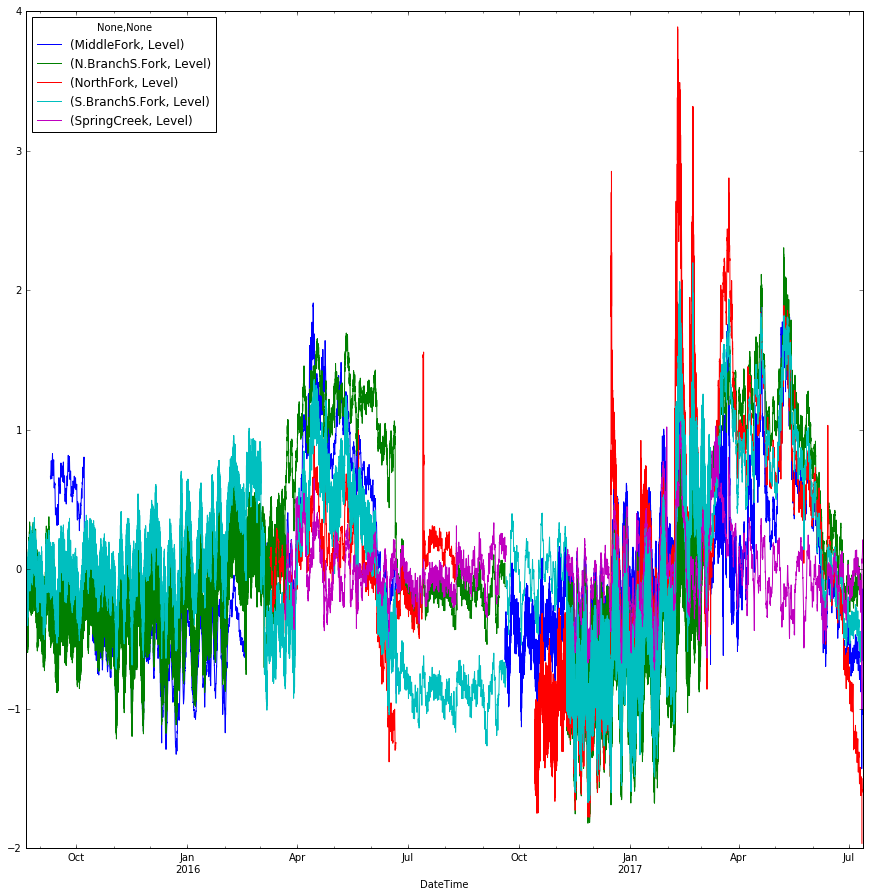

In [8]:
d[names].plot()
plt.savefig(figplace+"combined_raw_plots.pdf")
d[names].to_clipboard()

In [9]:
pdf = PdfPages(figplace+'jumpfix_levels.pdf')
plt.figure()
d[names].plot()
pdf.savefig()
plt.close()

for name in names:
    
    plt.figure(name)
    d[name].plot()
    plt.title(name)
    plt.ylabel("Transducer Level (ft)")
    pdf.savefig()
    plt.close()
pdf.close()

List beginning and end times of each dataset.

In [10]:
for col in d.columns:
    print("{:} from {:} to {:}".format(col,d[col].first_valid_index(), d[col].last_valid_index()))

('MiddleFork', 'Level') from 2015-09-09 16:00:00 to 2017-07-12 15:00:00
('N.BranchS.Fork', 'Level') from 2015-08-20 13:30:00 to 2017-07-11 12:00:00
('NorthFork', 'Level') from 2016-03-09 09:30:00 to 2017-07-11 18:30:00
('S.BranchS.Fork', 'Level') from 2015-08-20 10:30:00 to 2017-07-11 11:00:00
('SpringCreek', 'Level') from 2016-03-21 17:00:00 to 2017-07-12 14:30:00


http://mesowest.utah.edu/cgi-bin/droman/meso_base_dyn.cgi?stn=E8702&unit=0&timetype=LOCAL<br>
http://mesowest.utah.edu/cgi-bin/droman/meso_base_dyn.cgi?stn=C8844&unit=0&timetype=LOCAL

download barometric data from Mesowest

In [11]:
def baroget(d,stn):
    '''
    returns barometric pressure data from Mesowest
    token = token from Mesowest
    stn = station string
    start = start date YYYYMMDDHHMM
    end = end date YYYYMMDDHHMM; optional, defaults to beginning of current day
    '''
    
    token = "1ab92e63dd924c6189e6d5e1015c2645"
    begdate = datetime.strftime(d.index[0],"%Y%m%d%H%M")
    enddate = datetime.strftime(d.index[-1],"%Y%m%d%H%M")
    addrs = 'https://api.mesowest.net/v2/stations/timeseries?token={:}&stid={:}&start={:}&end={:}&units=pres|mb&output=csv'
    html = addrs.format(token, stn, begdate, enddate)
    baro = pd.read_csv(html,skiprows=8,usecols=[1,2,15],index_col=0,parse_dates=True,names=['datetime','pressure_pascals','precip_mm'])
    
    return baro

def barom(baro):
    barores = baro.resample('1min').mean()
    barores = barores.interpolate(how='time')
    barores = barores.resample('30min').mean()
    barores['baro_ft'] = barores['pressure_pascals']*0.000334562
    barores['pressure_pascals'].plot()
    return barores

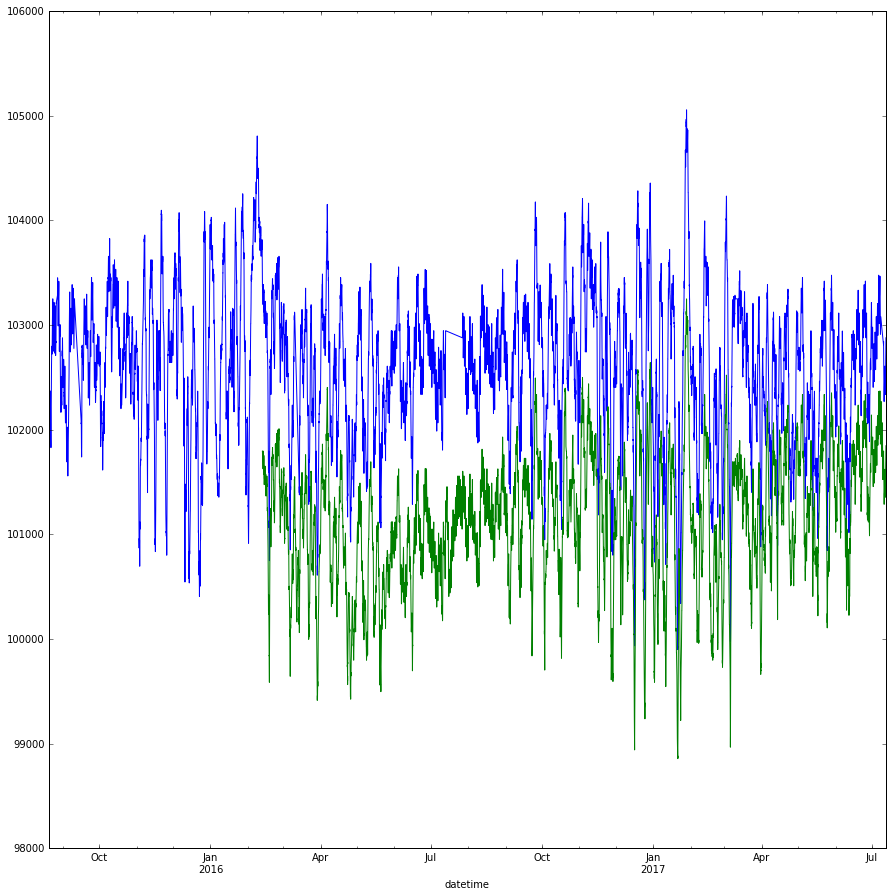

In [12]:
station = "C8844"
baro = baroget(d, station)
baroHunt = barom(baro)

station = "E8702"
baro = baroget(d, station)
baroEden = barom(baro)

In [13]:
baroHunt['baroHunt_ft'] = baroHunt['baro_ft']
baroEden['baroEden_ft'] = baroEden['baro_ft']
baroEden.drop(['pressure_pascals','precip_mm','baro_ft'],axis=1,inplace=True)
baroHunt.drop(['pressure_pascals','precip_mm','baro_ft'],axis=1,inplace=True)
baro = pd.concat([baroHunt,baroEden], axis=1)

In [14]:
d.columns = d.columns.droplevel(1)
dd = pd.concat([baro,d], axis=1)

delete missing interval in baro data and fill in with data from nearby station

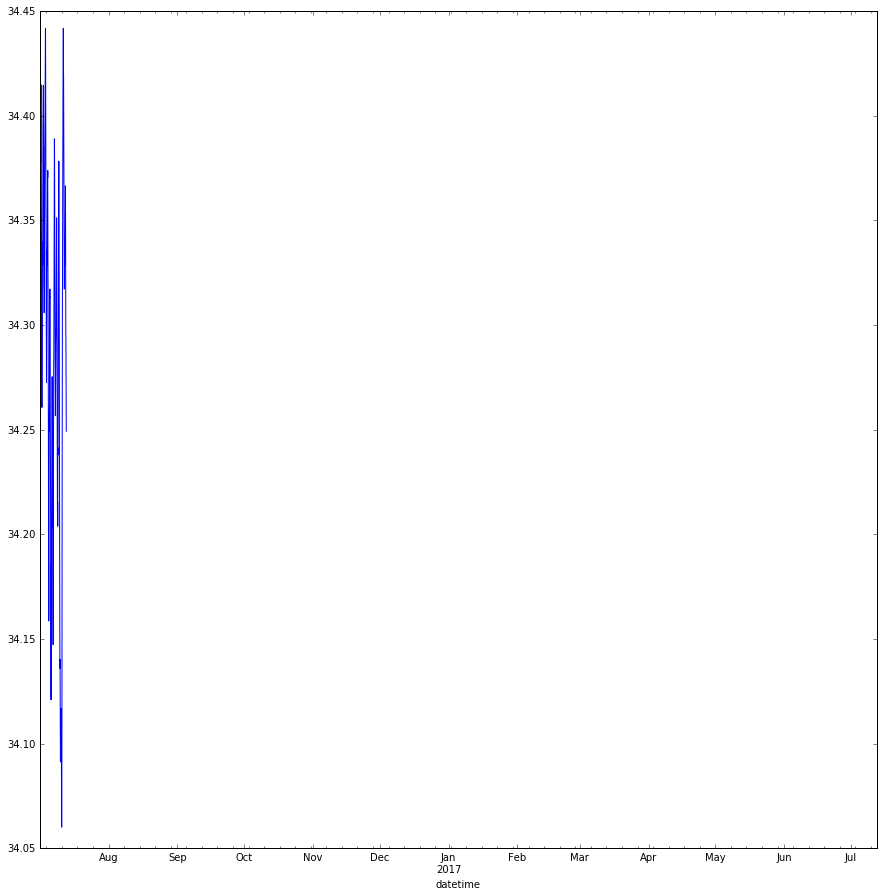

In [15]:
dd.loc[pd.datetime(2016,7,13):pd.datetime(2017,7,28),'baroHunt_ft'] = np.nan
dd[(dd.index > pd.datetime(2016,7,1))&(dd.index < pd.datetime(2017,7,28))]['baroHunt_ft'].plot()

In [16]:
dd

,baroHunt_ft,baroEden_ft,MiddleFork,N.BranchS.Fork,NorthFork,S.BranchS.Fork,SpringCreek
datetime,,,,,,,
2015-08-20 10:30:00,34.294589,NaN,NaN,NaN,NaN,-0.609948,NaN
2015-08-20 11:00:00,34.294589,NaN,NaN,NaN,NaN,-0.736235,NaN
2015-08-20 11:30:00,34.297800,NaN,NaN,NaN,NaN,0.005432,NaN
2015-08-20 12:00:00,34.305921,NaN,NaN,NaN,NaN,-0.005375,NaN
2015-08-20 12:30:00,34.309130,NaN,NaN,NaN,NaN,-0.154881,NaN
2015-08-20 13:00:00,34.317249,NaN,NaN,NaN,NaN,-0.118058,NaN
2015-08-20 13:30:00,34.317249,NaN,NaN,-0.759274,NaN,-0.195138,NaN
2015-08-20 14:00:00,34.317475,NaN,NaN,-0.759408,NaN,-0.043867,NaN
2015-08-20 14:30:00,34.327787,NaN,NaN,-1.186110,NaN,-0.213431,NaN


(1.165664015999484, -4.9959594664873972)

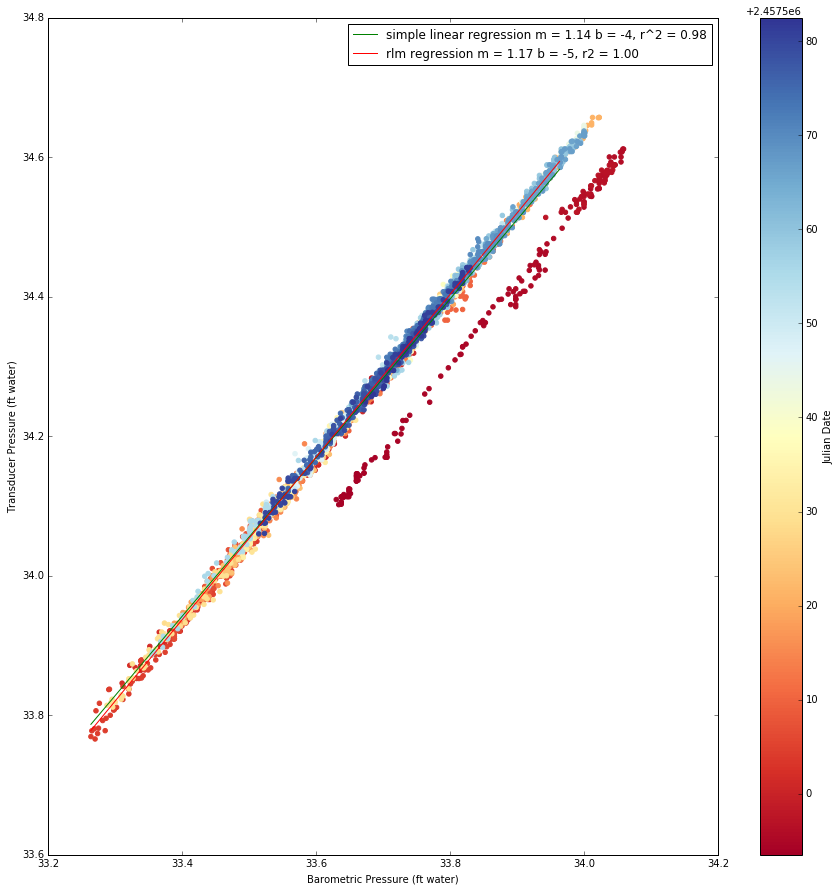

In [17]:
gg = dd.dropna(subset=['baroHunt_ft','baroEden_ft'])
gg = gg[(gg.index > pd.datetime(2016,4,15))&(gg.index < pd.datetime(2017,7,15))]
y = gg['baroHunt_ft']
x0 = gg['baroEden_ft']
w = gg.index.to_julian_date()
scatterColor(x0,y,w)

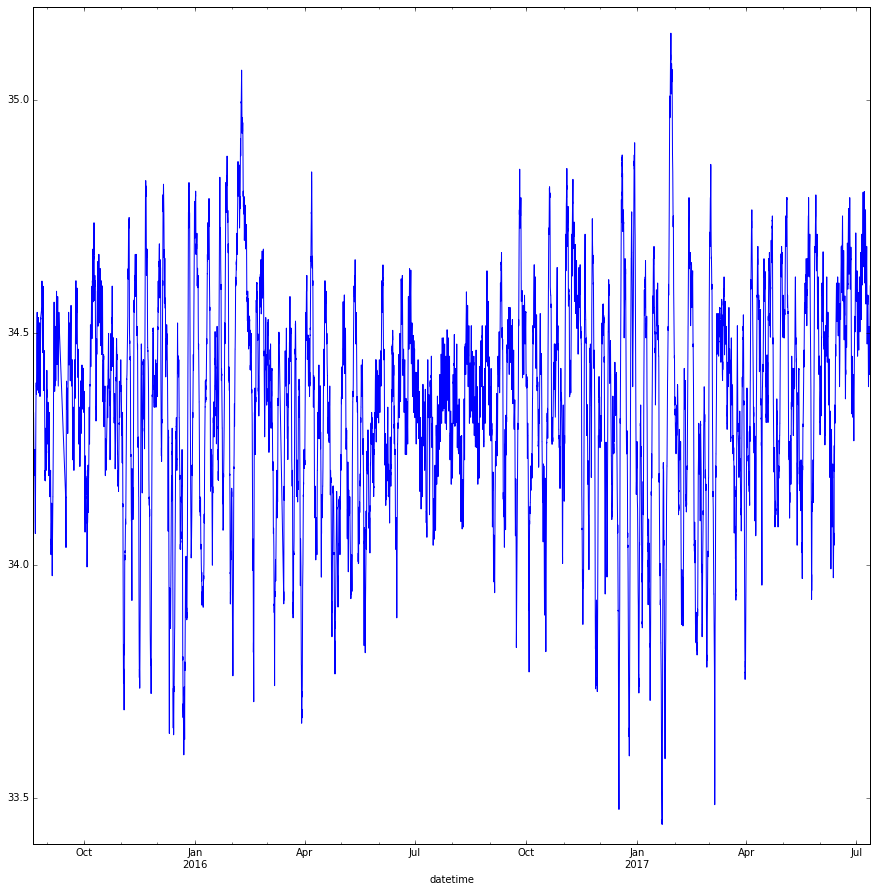

In [18]:
def fillna(x):
    if np.isnan(x[0]):
        return x[1]*1.1575336968219394-4.8411176123756503
    else:
        return x[0]

dd['Barometer'] = dd[['baroHunt_ft','baroEden_ft']].apply(lambda x: fillna(x),1)
dd['Barometer'].plot()

In [19]:
#dd.xs('Level',axis=1,drop_level=True)
dd.columns #= dd.columns.droplevel(1)

Index(['baroHunt_ft', 'baroEden_ft', 'MiddleFork', 'N.BranchS.Fork',
       'NorthFork', 'S.BranchS.Fork', 'SpringCreek', 'Barometer'],
      dtype='object')

In [20]:
fits = {}
con = {}
slp = {}
rsq = {}
for name in names:
    con[name] = []
    slp[name] = []
    rsq[name] = []
    for dmon in range(4,12):
        for dday in range(1,25):
            gg = dd[(dd.index > pd.datetime(2016,dmon,dday))&(dd.index < pd.datetime(2016,dmon,dday+2))]
            gg['BaroShift'] = gg['Barometer'].shift(-12)
            gg = gg.dropna(subset=[name,'BaroShift'])
            y = gg[name]
            x0 = gg['BaroShift']
            try:
                slope,const,r2 = esRLM(x0,y)
                if abs(slope-1.0) < 0.1:
                    con[name].append(const)
                    slp[name].append(slope)
                    rsq[name].append(r2)
            except:
                pass
    fits[name]=[np.mean(con[name]),np.mean(slp[name]),np.mean(rsq[name])]
    print(name, fits[name])

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


MiddleFork [-33.818183968871494, 0.98263905066090018, 0.6000675627556048]
N.BranchS.Fork [-33.437163725916186, 0.98262005690028331, 0.89816540997893446]
NorthFork [-34.007806963221292, 0.98408639431983713, 0.74983729715546588]
S.BranchS.Fork [-34.281772629790105, 0.98166421801400849, 0.79565516605948272]
SpringCreek [-33.533285132881424, 0.97578195206524421, 0.946302541895503]


0.240752436714


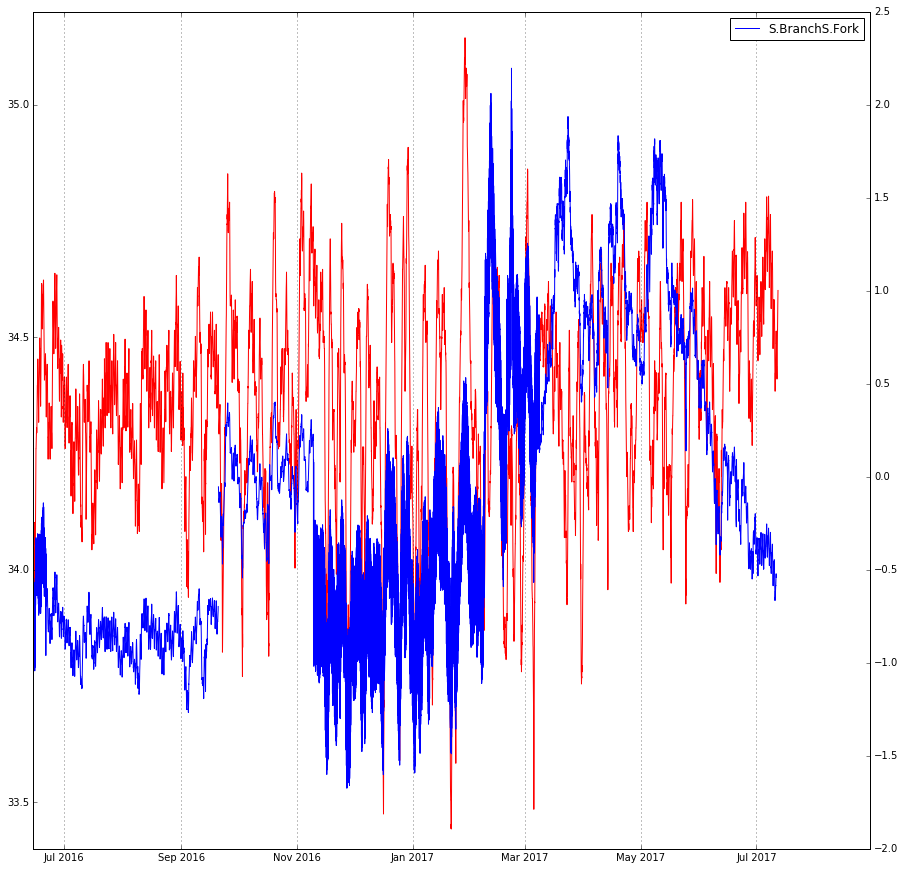

In [21]:
strt = pd.datetime(2016,6,15)
end =  pd.datetime(2017,8,30)
shif = -12
mm = dd[(dd.index > strt)&(dd.index < end)]
x = mm.index
y1 = mm['Barometer'].shift(shif)
y2 = mm[names[3]]
print(crosscorr(y1,y2))
plt.plot(x,y1,color='red')
plt.gca().xaxis.grid(True)
plt.twinx()
plt.plot(x,y2,color='blue')

plt.xlim(strt,end)
#plt.grid(axis='both')
plt.legend()

In [22]:
dd['baroshift'] = dd['Barometer'].shift(12)

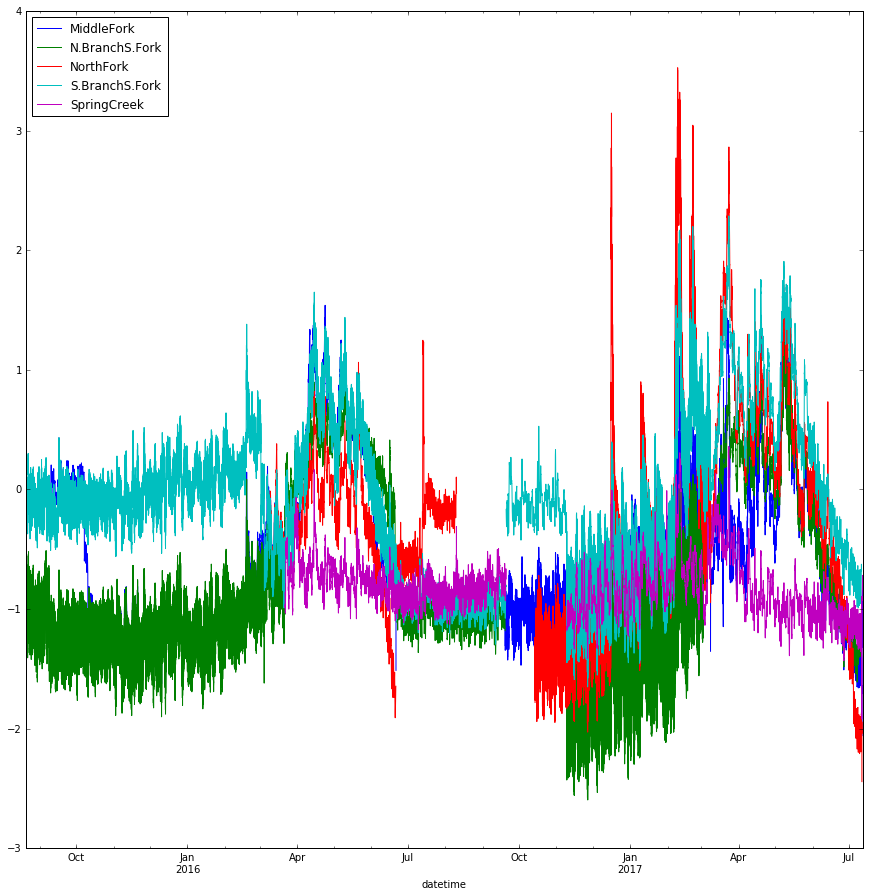

In [23]:

for i in range(len(names)):
    dd['adj'+ names[i]] = dd[[names[i],'baroshift']].apply(lambda x: x[0] - (x[1]+ fits[names[i]][0]),1)
    dd['adj'+ names[i]].plot(label=names[i])

plt.legend(loc=2)
#plt.xlim('8/15/2016','11/2/2016')
#plt.ylim(-1.5,-1)

In [24]:
dd.to_clipboard()

In [25]:
dd.to_pickle(xleplace+"baro_removed.pickle")

In [26]:
dd = pd.read_pickle(xleplace+"baro_removed.pickle")

In [27]:
flow = pd.read_excel(xleplace+'justflows.xlsx',index_col=2)

In [28]:
NFcorr = dd.ix['6/21/2016 8:30','adjNorthFork'] - dd.ix['6/21/2016 10:00','adjNorthFork']
dd.ix['6/21/2016 10:00':'8/10/2016 13:00','adjNorthFork'] = dd.ix['6/21/2016 10:00':'8/10/2016 13:00','adjNorthFork'] + NFcorr 

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


In [29]:
SBSFcorr1 = dd.ix['3/1/2016 17:30','adjS.BranchS.Fork'] - dd.ix['3/1/2016 18:00','adjS.BranchS.Fork']
dd.ix['8/20/2015 4:30':'3/1/2016 17:30','adjS.BranchS.Fork'] = dd.ix['8/20/2015 4:30':'3/1/2016 17:30',
                                                                     'adjS.BranchS.Fork'] - SBSFcorr1 - 0.5

SBSFcorr2 = dd.ix['9/20/2016 9:30','adjS.BranchS.Fork'] - dd.ix['9/20/2016 13:00','adjS.BranchS.Fork']
dd.ix['9/20/2016 13:00':'11/9/2016 14:00','adjS.BranchS.Fork'] = dd.ix['9/20/2016 13:00':'11/9/2016 14:00',
                                                                       'adjS.BranchS.Fork'] + SBSFcorr2 

In [30]:
NBSFcorr = dd.ix['3/21/2016 15:30',
                 'adjN.BranchS.Fork'] - dd.ix['3/21/2016 16:00',
                                              'adjN.BranchS.Fork']
dd.ix['3/21/2016 15:30':'6/20/2016 18:30:00', 'adjN.BranchS.Fork'] = dd.ix['3/21/2016 15:30':'6/20/2016 18:30:00', 
                                                                           'adjN.BranchS.Fork'] + NBSFcorr 

In [31]:
dd.ix['6/21/2016 11:00','adjMiddleFork'] = np.nan
MFcorr1 = dd.ix['10/7/2015 17:00','adjMiddleFork'] - dd.ix['10/7/2015 16:00','adjMiddleFork']
MFcorr2 = dd.ix['10/10/2015 15:30','adjMiddleFork'] - dd.ix['10/10/2015 10:00','adjMiddleFork']
dd.ix[:'10/7/2015 17:00','adjMiddleFork'] = dd.ix[:'10/7/2015 17:00','adjMiddleFork'] + MFcorr1 + MFcorr2


MiddleFork


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in power
  


MiddleFork [  1.03101359   2.11413536  50.44265942] [  1.16140513   1.18014048  40.28803075]


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\matplotlib\scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


N.BranchS.Fork
N.BranchS.Fork [   0.70812796    1.81542144  106.76583964] [  1.5045223    1.91231779  75.45427876]
NorthFork
NorthFork [   2.9767976     3.69658054  225.38236038] [  1.96284257   1.          62.27938692]
S.BranchS.Fork
S.BranchS.Fork [  0.62401182   0.9377731   52.1429432 ] [  1.36415906   1.34587706  50.69754913]
SpringCreek
SpringCreek [ 14.09779077  30.2805179   45.2281112 ] [ 2.53399623  3.51022152  1.        ]


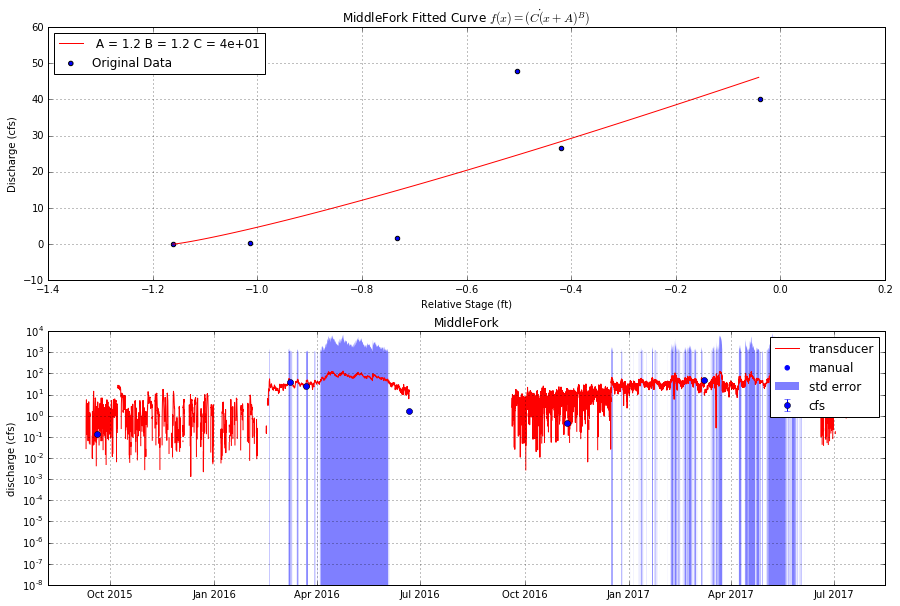

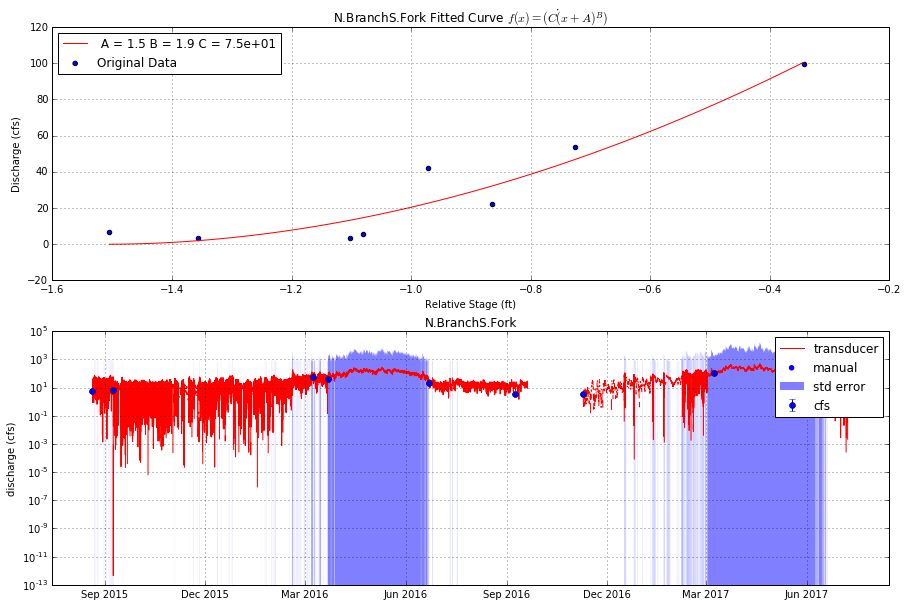

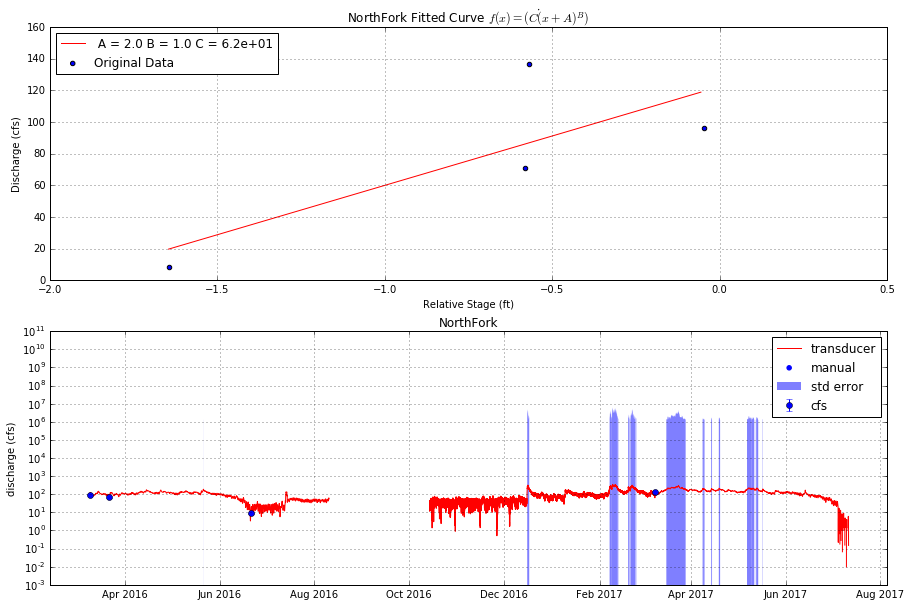

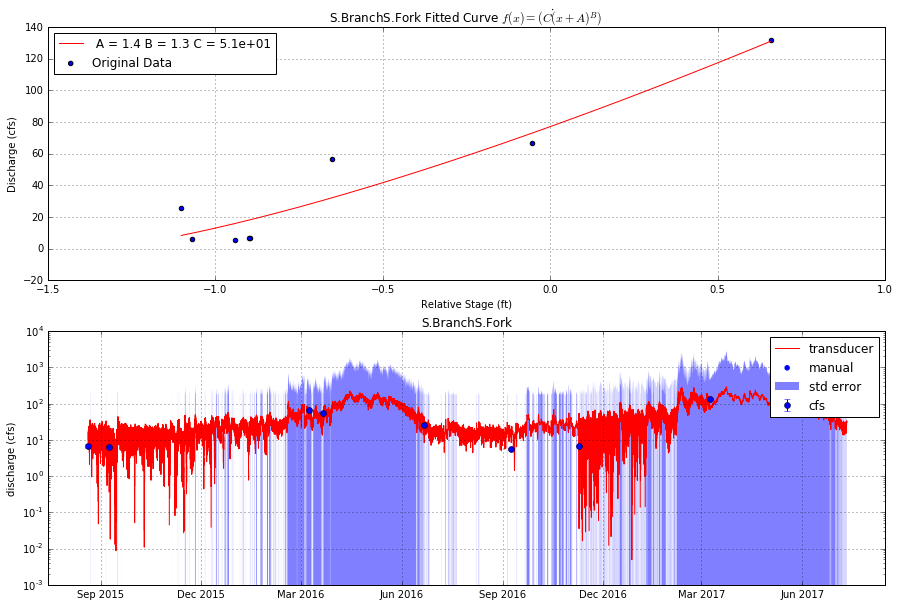

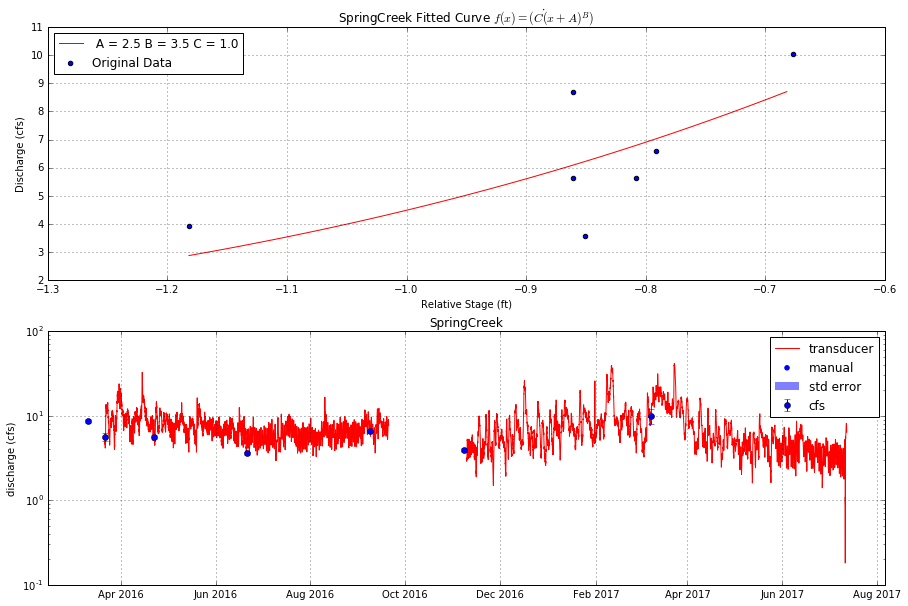

In [32]:
Qcolumns = names
forks = names
rcParams['figure.figsize'] = 15, 10
pdf = PdfPages(figplace+'finished_hydrographs_relationships.pdf')
def func(x, a, b, c):
    return c*(x + a)**(b)

#def func(x, a, b):
#    return a * np.exp(b * x)

for i in range(len(Qcolumns)):
    print(Qcolumns[i])
    dfSub = dd['adj' + Qcolumns[i]].to_frame()
    dfSub.dropna(inplace=True)
    MFflow = flow[(flow.fork==forks[i])&(flow.cfs.notnull())]
    
    MFQ = []
    for j in range(len(MFflow)):
        MFQ.append(wa.transport.fcl(dfSub, MFflow.index[j])['adj' + Qcolumns[i]])

    x = MFQ
    yn = MFflow.cfs
    #print(MFflow.err_CFS)
    #yerr = MFflow.err_CFS.values

    popt, pcov = curve_fit(func, x, yn,
                           bounds = ([0.0,1.0,1.0],[100.0,10.0,500.0]),
                          max_nfev=8000)
    
    sterr = np.sqrt(np.diag(pcov))
    print(names[i], sterr, popt)
    plt.figure(i)
    plt.subplot(211)
    plt.scatter(x, yn, label="Original Data")
    xb = np.arange(np.min(x),np.max(x),0.01)
    yb = [func(j, popt[0], popt[1], popt[2]) for j in xb]
    equation = 'Fitted Curve ' + r'$f(x)= (C \dot (x+A)^{B})$ '

    eqlab = ' A = {:.2} B = {:.2} C = {:.2}'
    plt.plot(xb, yb, 'r-', label= eqlab.format(popt[0],popt[1],popt[2]))
 
    plt.legend(loc=2, scatterpoints=1)
    plt.grid()
    plt.ylabel('Discharge (cfs)')
    plt.xlabel('Relative Stage (ft)')
    plt.title(names[i]+" "+equation)

    dd[forks[i] + '_cfs'] = dd['adj' + Qcolumns[i]].apply(lambda x: func(x, popt[0],popt[1],popt[2]), 1)
    dd[forks[i] + '_cfs_min'] = dd['adj'+ Qcolumns[i]].apply(lambda x: func(x, popt[0]-sterr[0], popt[1]-sterr[1], popt[2]-sterr[2]),1)
    dd[forks[i] + '_cfs_max'] = dd['adj'+ Qcolumns[i]].apply(lambda x: func(x, popt[0]+sterr[0], popt[1]+sterr[1], popt[2]+sterr[2]),1)
    x = dd.index
    y = dd[forks[i] + '_cfs']
    y2 = dd[forks[i] + '_cfs_min']
    y3 = dd[forks[i] + '_cfs_max']
    x1 = MFflow.index
    y1 = MFflow.cfs
    yerr = MFflow.err_CFS.values
    
    plt.subplot(212)
    plt.plot(x,y,color='red',label='transducer')
    plt.scatter(x1,y1,color='blue',label='manual')
    plt.errorbar(x1,y1,yerr=yerr,fmt='o')
    plt.fill_between(x,y2,y3,alpha=0.5,linewidth=0.0,label='std error')
    plt.yscale('log')
    plt.legend(scatterpoints=1)
    plt.ylabel('discharge (cfs)')
    plt.grid()
    plt.title(forks[i])
    pdf.savefig()

pdf.close()


In [33]:
forks

['MiddleFork', 'N.BranchS.Fork', 'NorthFork', 'S.BranchS.Fork', 'SpringCreek']

In [34]:
dd.columns

Index(['baroHunt_ft', 'baroEden_ft', 'MiddleFork', 'N.BranchS.Fork',
       'NorthFork', 'S.BranchS.Fork', 'SpringCreek', 'Barometer', 'baroshift',
       'adjMiddleFork', 'adjN.BranchS.Fork', 'adjNorthFork',
       'adjS.BranchS.Fork', 'adjSpringCreek', 'MiddleFork_cfs',
       'MiddleFork_cfs_min', 'MiddleFork_cfs_max', 'N.BranchS.Fork_cfs',
       'N.BranchS.Fork_cfs_min', 'N.BranchS.Fork_cfs_max', 'NorthFork_cfs',
       'NorthFork_cfs_min', 'NorthFork_cfs_max', 'S.BranchS.Fork_cfs',
       'S.BranchS.Fork_cfs_min', 'S.BranchS.Fork_cfs_max', 'SpringCreek_cfs',
       'SpringCreek_cfs_min', 'SpringCreek_cfs_max'],
      dtype='object')

In [35]:
dropcol = [u'baroHunt_ft', u'baroEden_ft', u'MiddleFork', u'N.BranchS.Fork',
           u'NorthFork', u'S.BranchS.Fork', u'SpringCreek', u'Barometer',
           u'baroshift', u'adjMiddleFork', u'adjN.BranchS.Fork', u'adjNorthFork',
           u'adjS.BranchS.Fork', u'adjSpringCreek', u'MiddleFork_cfs_min', 
           u'MiddleFork_cfs_max', u'N.BranchS.Fork_cfs_min', u'N.BranchS.Fork_cfs_max', 
           u'NorthFork_cfs_min', u'NorthFork_cfs_max', 
           u'S.BranchS.Fork_cfs_min', u'S.BranchS.Fork_cfs_max',
           u'SpringCreek_cfs_min', u'SpringCreek_cfs_max']

In [36]:
gg = dd.drop(dropcol, axis=1)

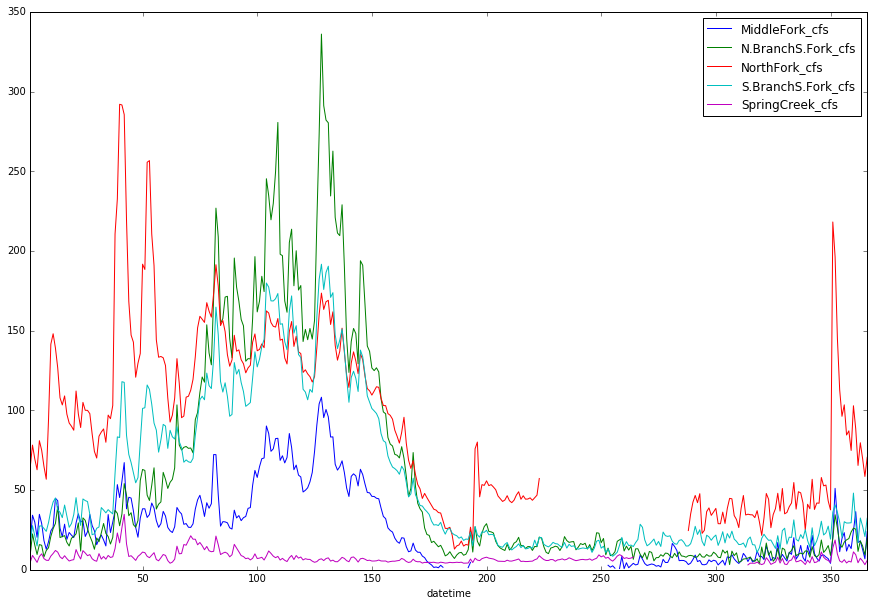

In [37]:
gg.groupby(gg.index.dayofyear).mean().plot()

In [38]:
hourly_cfd = gg.resample('1D').median()*24*3600
discrete_sums_fk = hourly_cfd.groupby(hourly_cfd.index.dayofyear).mean().cumsum().iloc[-1,:]*0.0283168/1000000
discrt_sums_fk = discrete_sums_fk.to_frame()
discrt_sums_fk.columns = ['discharge millions m3']
discrt_sums_fk['percent flow'] = discrt_sums_fk['discharge millions m3'].apply(lambda x: x/discrt_sums_fk['discharge millions m3'].sum(),1)

In [39]:
discrt_sums_fk

,discharge millions m3,percent flow
MiddleFork_cfs,19.513644,0.101661
N.BranchS.Fork_cfs,49.373895,0.257226
NorthFork_cfs,69.001022,0.359479
S.BranchS.Fork_cfs,48.235224,0.251294
SpringCreek_cfs,5.823623,0.030340


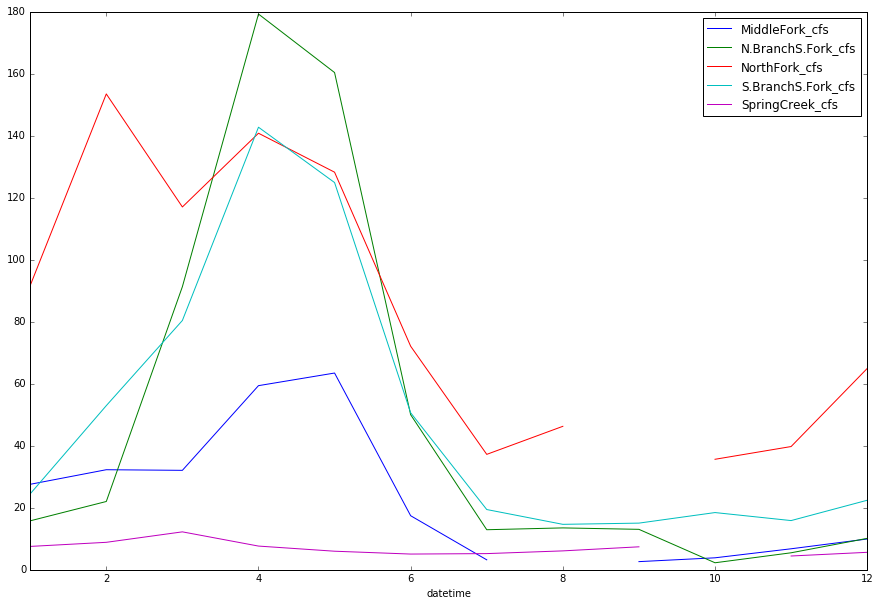

In [40]:
gg.groupby(gg.index.month).median().plot()

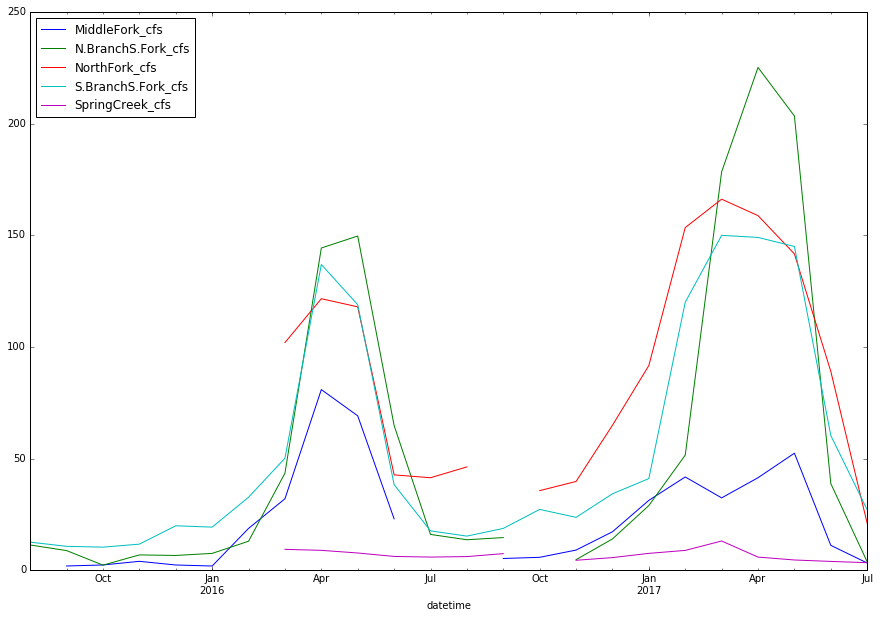

In [41]:
gg.groupby(pd.TimeGrouper("MS")).median().plot()

In [42]:
gg.groupby(gg.index.month).mean().to_clipboard()

In [43]:
dlyflw = gg.resample('D').mean()*86400.0
dlyflw.columns = [col[:-4]+'_cfd' for col in dlyflw.columns]
dlyflw.head()

,MiddleFork_cfd,N.BranchS.Fork_cfd,NorthFork_cfd,S.BranchS.Fork_cfd,SpringCreek_cfd
datetime,,,,,
2015-08-20,NaN,7.918317e+05,NaN,1.008267e+06,NaN
2015-08-21,NaN,1.285360e+06,NaN,9.856489e+05,NaN
2015-08-22,NaN,2.468106e+06,NaN,1.740618e+06,NaN
2015-08-23,NaN,1.990553e+06,NaN,1.046852e+06,NaN
2015-08-24,NaN,1.436696e+06,NaN,1.214145e+06,NaN


In [55]:
dlyintflw = dlyflw.interpolate(method='time')
dlyintflw.dropna(inplace=True)

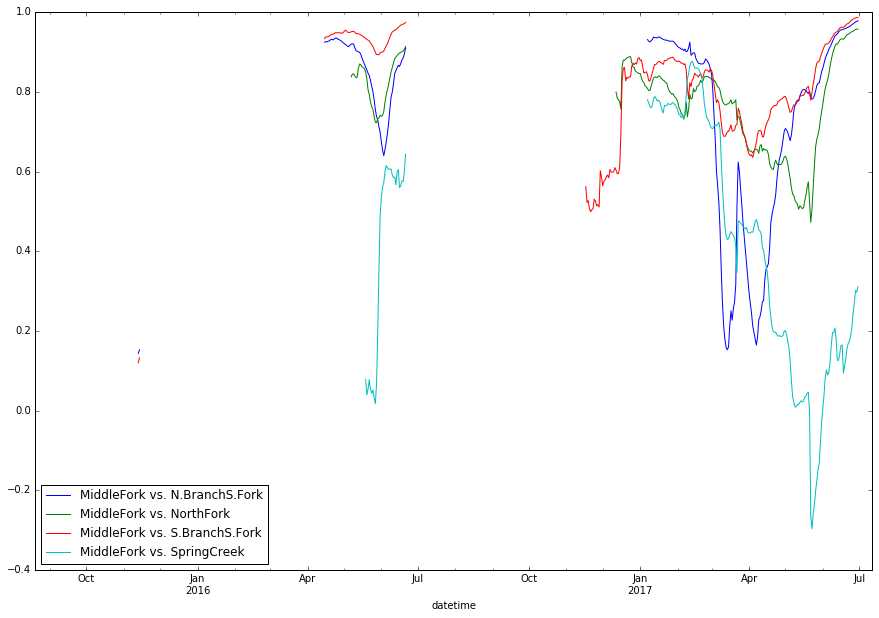

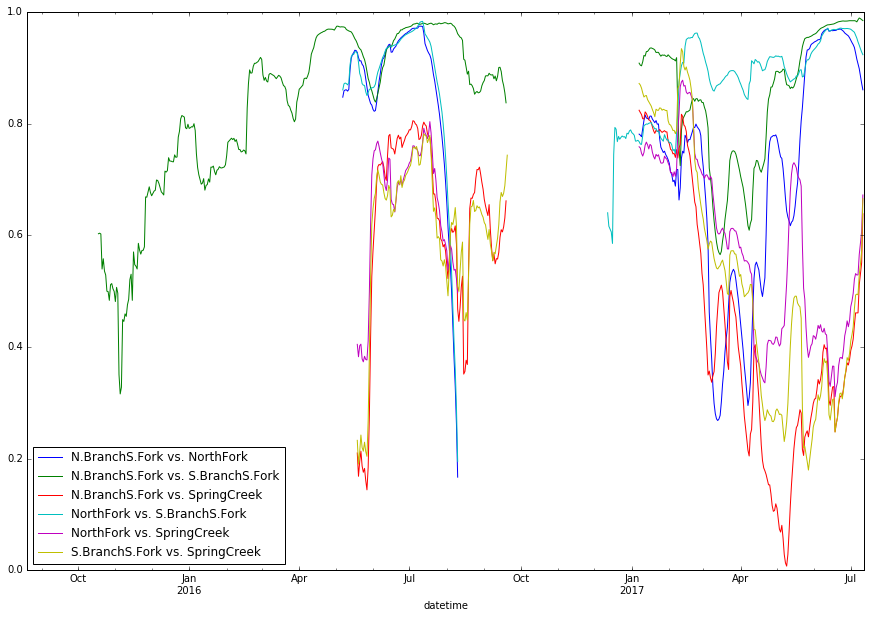

In [79]:
#for i in range(50,100,10):
i=0
for col in dlyflw.columns:
    i += 1
    if i == 2:
        plt.legend(loc=3)
        plt.figure()
    for col2 in dlyflw.columns[i:]:
        if col == col2:   
            pass
        else:
            dlyflw[col].rolling(window=60).corr(dlyflw[col2]).plot(label='{:} vs. {:}'.format(col[:-4],col2[:-4]))
    
plt.legend(loc=3)

In [44]:
dfdict = {}

for col in dlyflw.columns:
    df = dlyflw[col]
    dfdict[col] = df.dropna().to_frame()
    dfdict[col]['Eckhardt baseflow ' + col] = wa.Eckhardt(dfdict[col][col],BFI=0.7)
    #dfdict[col]['bf_Ly_' + col] = wa.Lyne_Hollick(dfdict[col][col].values, alpha = 0.96)
bf = pd.concat(dfdict,axis=1)

In [45]:
bf.columns = bf.columns.droplevel()

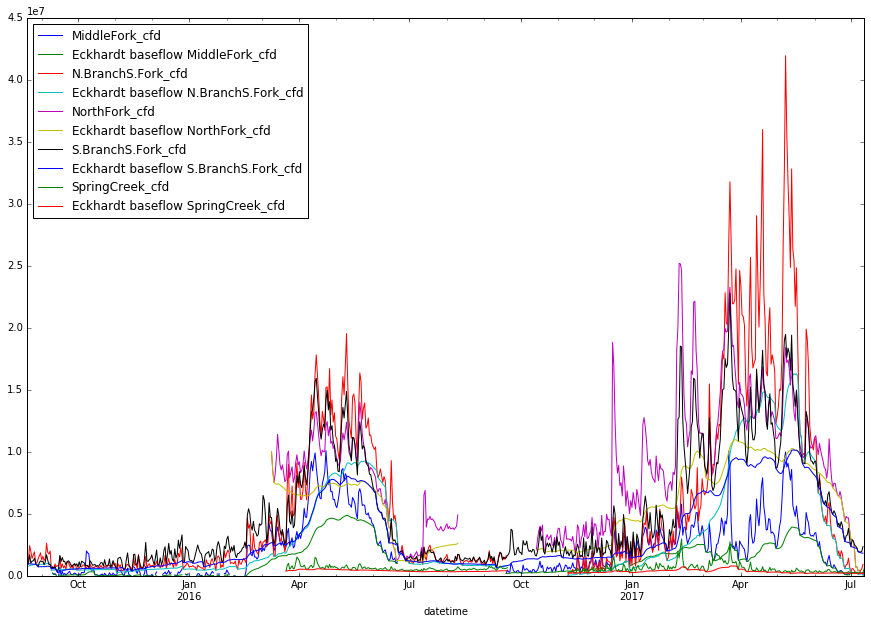

In [46]:
bf.plot()

In [47]:
bf_acft = bf.groupby(bf.index.month).mean()*0.000698272
bf_acft.columns = [col[:-4]+' ac-ft/mo' for col in bf_acft.columns]
bf_acft.head()

,MiddleFork ac-ft/mo,Eckhardt baseflow MiddleFork ac-ft/mo,N.BranchS.Fork ac-ft/mo,Eckhardt baseflow N.BranchS.Fork ac-ft/mo,NorthFork ac-ft/mo,Eckhardt baseflow NorthFork ac-ft/mo,S.BranchS.Fork ac-ft/mo,Eckhardt baseflow S.BranchS.Fork ac-ft/mo,SpringCreek ac-ft/mo,Eckhardt baseflow SpringCreek ac-ft/mo
datetime,,,,,,,,,,
1,1230.114860,656.156943,1288.052135,641.427358,5654.746067,3636.054357,1908.624804,1094.780911,489.282386,280.356734
2,1847.120351,972.313083,2423.470962,1133.594757,10264.560289,5661.715263,4544.301700,2134.877632,674.457854,382.673340
3,2166.006958,1160.729853,7085.993396,3185.965472,8442.578097,5754.940033,6044.519508,3600.812437,763.635610,400.106663
4,3746.181129,1905.274006,11278.272655,6765.188998,8548.800072,6023.228423,8550.226403,5262.222778,478.785929,330.819499
5,4005.843213,2713.642584,11469.602419,7502.486601,8128.985840,5919.764327,8196.470456,5871.700088,374.709008,267.912407


In [48]:
bf_yrmo_acft = bf.groupby(pd.TimeGrouper('MS')).mean()*0.000698272
bf_yrmo_acft.columns = [col[:-4]+' ac-ft/mo' for col in bf_yrmo_acft.columns]
bf_yrmo_acft.to_clipboard()

In [81]:
drive = 'E:/Google Drive/WORK/Ogden Valley/'

In [82]:
ugs_writer = pd.ExcelWriter(drive + 'finished_hydrogrphs_data.xlsx')
dd.to_excel(ugs_writer, 'processed data')
dlyflw.to_excel(ugs_writer, 'daily data cfd')
bf_acft.to_excel(ugs_writer, 'average acft per month')
bf_yrmo_acft.to_excel(ugs_writer, 'monthly flow acft')
discrt_sums_fk.to_excel(ugs_writer, 'yearly flow totals m3 e6')
ugs_writer.save()
print(drive + 'finished_hydrogrphs_data.xlsx')

E:/Google Drive/WORK/Ogden Valley/finished_hydrogrphs_data.xlsx


In [80]:
dd.head()

,baroHunt_ft,baroEden_ft,MiddleFork,N.BranchS.Fork,NorthFork,S.BranchS.Fork,SpringCreek,Barometer,baroshift,adjMiddleFork,...,N.BranchS.Fork_cfs_max,NorthFork_cfs,NorthFork_cfs_min,NorthFork_cfs_max,S.BranchS.Fork_cfs,S.BranchS.Fork_cfs_min,S.BranchS.Fork_cfs_max,SpringCreek_cfs,SpringCreek_cfs_min,SpringCreek_cfs_max
datetime,,,,,,,,,,,,,,,,,,,,,
2015-08-20 10:30:00,34.294589,NaN,NaN,NaN,NaN,-0.609948,NaN,34.294589,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-20 11:00:00,34.294589,NaN,NaN,NaN,NaN,-0.736235,NaN,34.294589,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-20 11:30:00,34.297800,NaN,NaN,NaN,NaN,0.005432,NaN,34.297800,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-20 12:00:00,34.305921,NaN,NaN,NaN,NaN,-0.005375,NaN,34.305921,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-20 12:30:00,34.309130,NaN,NaN,NaN,NaN,-0.154881,NaN,34.309130,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
outdf = {}
for name in names:
    print(name)
    stage = flow[(flow['fork'] == name)&flow['stg_ft'].notnull()]
    dfSub = dd['adj' + name].to_frame()
    dfSub.dropna(inplace=True)
    out = wa.fix_drift(dfSub,stage,meas= 'adj' + name, manmeas='stg_ft')
    outdf[name] = out[0]
    print(out[1])
    
comb = pd.concat([outdf[name] for name in names], axis=1, keys=names)

MiddleFork


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\wellapplication\transport.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  manualfile['julian'] = manualfile.index.to_julian_date()
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\core\indexing.py:561: SettingWithCopyWarning: 
A value is 

                                                            0
begining    fork       MiddleFork
hydroid          3356
st...
end         fork        MiddleFork
hydroid           3356
...
first_meas                                               0.17
intercept                                             1.49958
last_meas                                                 0.9
slope                                            -0.000301902
N.BranchS.Fork
                                                            0
begining    fork       N.BranchS.Fork
hydroid             ...
end         fork       N.BranchS.Fork
hydroid             ...
first_meas                                               0.31
intercept                                             1.83275
last_meas                                                 1.2
slope                                             -0.00122421
NorthFork


ValueError: No objects to concatenate

# USGS Data

## Flow Data

In [6]:
rcParams['figure.figsize'] = 15, 10

dvsites = [10137680, 10137700, 10137800, 10137780,
           10137290, 10137300, 10137500, 10137900,
           10138000, 10139000, 10139300, 10140000,
           10139500, 10140100]
writer = pd.ExcelWriter(drive + 'USGS_output.xlsx')

In [7]:
ov = wa.nwis('dv',dvsites,'sites')
ov.data.drop('qualifiers',axis=1,inplace=True)
ovbysite = ov.data.unstack(level=0)
ovbysite.columns = ovbysite.columns.droplevel(0)
ovbysite.to_excel(writer,'level_data')

connection successful
Gage height, feet skipped!
Gage height, feet skipped!


In [8]:
mean_monthly = ovbysite.groupby(pd.TimeGrouper('MS')).mean()
mean_monthly.to_excel(writer,'mean_monthly')
median_monthly = ovbysite.groupby(pd.TimeGrouper('MS')).median()
median_monthly.to_excel(writer,'median_monthly')

In [9]:
detail_ov_sites = ov.get_info(hasDataTypeCd='dv')
detail_ov_sites.to_excel(writer,'station_info')
detail_ov_sites

connection successful
https://waterservices.usgs.gov/nwis/site/?hasDataTypeCd=dv&endDT=2017-06-14&startDT=1800-01-01&sites=10137680%2C10137700%2C10137800%2C10137780%2C10137290%2C10137300%2C10137500%2C10137900%2C10138000%2C10139000%2C10139300%2C10140000%2C10139500%2C10140100&format=rdb


,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd
0,USGS,10137290,"CAUSEY RESERVOIR NEAR HUNTSVILLE, UTAH",LK,41.298552,-111.586874,S,NAD83,NaN,NaN,NaN,16020102
1,USGS,10137300,"SOUTH FK OGDEN R BL CAUSEY RES NR HUNTSVILLE, ...",ST,41.296052,-111.590485,F,NAD83,5491.90,20.0,NGVD29,16020102
2,USGS,10137500,"SOUTH FORK OGDEN RIVER NEAR HUNTSVILLE, UT",ST,41.268552,-111.674100,F,NAD83,5190.00,20.0,NGVD29,16020102
3,USGS,10137680,"NORTH FORK OGDEN RIVER NEAR EDEN, UTAH",ST,41.389661,-111.914942,F,NAD83,5750.00,20.0,NGVD29,16020102
4,USGS,10137700,"NORTH FORK OGDEN RIVER NEAR HUNTSVILLE, UTAH",ST,41.294386,-111.828550,F,NAD83,4903.81,20.0,NGVD29,16020102
5,USGS,10137780,"MIDDLE FK OGDEN RIVER AB DIV NR HUNTSVILLE, UTAH",ST,41.299662,-111.735215,S,NAD83,5400.00,20.0,NGVD29,16020102
6,USGS,10137800,"MIDDLE FORK OGDEN RIVER AT HUNTSVILLE, UTAH",ST,41.287441,-111.777160,F,NAD83,4915.41,20.0,NGVD29,16020102
7,USGS,10137900,"SPRING CREEK AT HUNTSVILLE, UTAH",ST,41.265219,-111.766049,F,NAD83,4902.99,20.0,NGVD29,16020102
8,USGS,10138000,"MIDDLE FORK OGDEN RIVER NEAR HUNTSVILLE, UTAH",ST,41.266608,-111.800772,F,NAD83,NaN,NaN,NaN,16020102
9,USGS,10139000,"PINEVIEW RESERVOIR NEAR OGDEN, UT",LK,41.255498,-111.841050,S,NAD83,NaN,NaN,NaN,16020102


In [10]:
namelist = detail_ov_sites.station_nm.apply(lambda x: str(x).title())
namedict = dict(zip(detail_ov_sites.site_no, namelist))

Data Loaded 
Type .ganttPlotter() after your defined object to make plot
Type .sitestats after your defined object to get summary stats


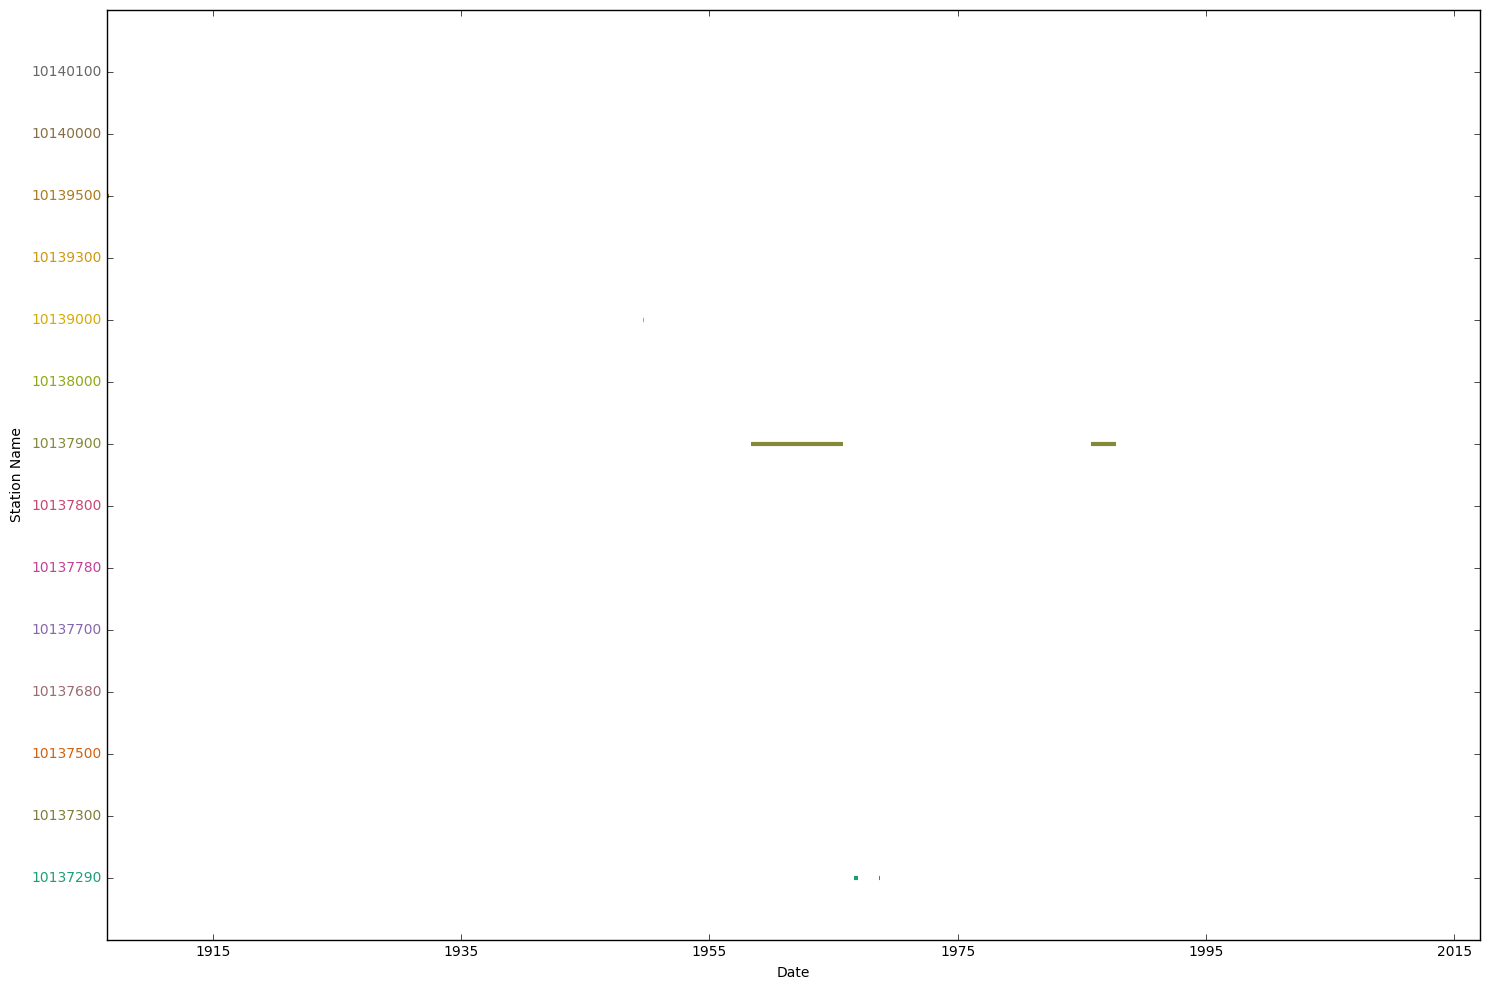

In [11]:
ovgnt = wa.gantt(ovbysite)
ovgnt.ganttPlotter()
plt.grid()
ovgnt.sitestats.to_excel(writer,'site_stats')

In [12]:
rcParams['figure.figsize'] = 15, 10
pdf = PdfPages(drive+'USGS_Station_Data.pdf')
i=0
for site in dvsites:
    st = wa.nwis('dv',site,'sites')
    if st.data is not None:
        i += 1
        if type(st.data.index) == pd.indexes.multi.MultiIndex:
            st.data.index = st.data.index.droplevel(0)

        midgrp_mo = st.data['value'].groupby(st.data.index.month).agg({'median':np.median,
                                                                       'mean':np.mean,
                                                                       'min':min,
                                                                       'max':max,
                                                                       '5 percent':lambda x: np.percentile(x, 5),
                                                                      '95 percent':lambda x: np.percentile(x, 95),
                                                                      'std':np.std,
                                                                      '2sd plus':lambda x: np.mean(x)+2*np.std(x),
                                                                      '2sd min':lambda x: np.mean(x)-2*np.std(x),
                                                                      'count':np.size})
        midgrp_mo.to_excel(writer,'mon_{:}'.format(site))
        midgrp_dy = st.data['value'].groupby(st.data.index.dayofyear).agg({'median':np.median,
                                                                       'mean':np.mean,
                                                                       'min':min,
                                                                       'max':max,
                                                                       '5 percent':lambda x: np.percentile(x, 5),
                                                                      '95 percent':lambda x: np.percentile(x, 95),
                                                                      'std':np.std,
                                                                      '2sd plus':lambda x: np.mean(x)+2*np.std(x),
                                                                      '2sd min':lambda x: np.mean(x)-2*np.std(x),
                                                                      'count':np.size})
        midgrp_dy.to_excel(writer,'dly_{:}'.format(site))
        plt.figure(i)
        plt.subplot(311)
        plt.plot(midgrp_mo.index, midgrp_mo['median'])
        plt.plot(midgrp_mo.index, midgrp_mo['mean'])
        plt.fill_between(midgrp_mo.index, midgrp_mo['5 percent'], 
                         midgrp_mo['95 percent'], alpha=0.5)
        plt.xlim(0,13)
        plt.xticks(range(1,13),
                   ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
        plt.grid()
        titlestr = 'Monthly Average Discharge: {:} ({:}) {:} - {:}'
        plt.title(titlestr.format(st.sites['station_nm'][0].title(),
                                  st.sites['site_no'][0],
                                  st.data.first_valid_index().year,
                                 st.data.last_valid_index().year))
        plt.ylabel('Discharge (cfs)')
        plt.yscale('log')

        
        plt.subplot(312)
        plt.plot(midgrp_dy.index, midgrp_dy['median'], label='median')
        plt.plot(midgrp_dy.index, midgrp_dy['mean'], label='mean')
        plt.fill_between(midgrp_dy.index, midgrp_dy['5 percent'], 
                         midgrp_dy['95 percent'], alpha=0.5, label='90th percentile')
        plt.xlim(0,365.25)
        plt.xticks(range(0,360,30),
                   ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
        plt.grid()
        plt.ylabel('Discharge (cfs)')
        titlestr = 'Daily Average Discharge: {:} ({:}) {:} - {:}'
        plt.title(titlestr.format(st.sites['station_nm'][0].title(),
                                  st.sites['site_no'][0],
                                  st.data.first_valid_index().year,
                                 st.data.last_valid_index().year))
        plt.legend()
        plt.subplot(313)
        df = wa.fdc(st.data,'value')
        plt.grid()
        plt.ylabel('Discharge (cfs)')
        plt.xlabel('Probability that discharge is met or exceeded')
        titlestr = 'Flow Duration Curve: {:} {:} - {:}'
        plt.title(titlestr.format(st.sites['station_nm'][0].title(),
                                  st.data.first_valid_index().year,
                                 st.data.last_valid_index().year))

        pdf.savefig()
        plt.close()
pdf.close()

connection successful
connection successful
connection successful
connection successful
connection successful
connection successful
connection successful
Gage height, feet skipped!


c:\users\paulinkenbrandt\documents\github\env\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


connection successful
connection successful
connection successful
connection successful
connection successful
connection successful
connection successful
Gage height, feet skipped!


In [13]:
writer.save()

In [ ]:
cmap = plt.cm.get_cmap('cool')
rcParams['figure.figsize'] = 15, 10
pdf = PdfPages(drive+'USGS_Station_Data_DOY.pdf')
i=0
for site in dvsites:
    st = wa.nwis('dv',site,'sites')
    if st.data is not None:
        i += 1
        if type(st.data.index) == pd.indexes.multi.MultiIndex:
            st.data.index = st.data.index.droplevel(0)

        st = wa.nwis('dv',site,'sites')
        if type(st.data.index) == pd.indexes.multi.MultiIndex:
            st.data.index = st.data.index.droplevel(0)

        fyr = st.data.first_valid_index().year
        lyr = st.data.last_valid_index().year

        norm = mpl.colors.Normalize(vmin=fyr, vmax=lyr)
        m = cm.ScalarMappable(norm=norm, cmap=cmap)

        m.set_array(range(fyr, lyr+1))

        for j in range(fyr, lyr+1):
            subdata = st.data[st.data.index.year == j]

            plt.plot(subdata.index.dayofyear,subdata.value, color= m.to_rgba(j), 
                     alpha = 0.75, label='')

        midgrp_dy = st.data['value'].groupby(st.data.index.dayofyear).agg({'median':np.median,
                                                                   'mean':np.mean,
                                                                   'min':min,
                                                                   'max':max,
                                                                   '5 percent':lambda x: np.percentile(x, 5),
                                                                  '95 percent':lambda x: np.percentile(x, 95),
                                                                  'std':np.std,
                                                                  '2sd plus':lambda x: np.mean(x)+2*np.std(x),
                                                                  '2sd min':lambda x: np.mean(x)-2*np.std(x),
                                                                  'count':np.size})   

        plt.plot(midgrp_dy.index, midgrp_dy['median'], label='median', linewidth=2)
        plt.plot(midgrp_dy.index, midgrp_dy['mean'], label='mean',linewidth=2)
        plt.fill_between(midgrp_dy.index, midgrp_dy['5 percent'], 
                         midgrp_dy['95 percent'], alpha=0.2, 
                         label='90th percentile',color='yellow',linewidth=0)
        plt.yscale('log')
        plt.grid()
        plt.ylabel('Discharge (cfs)')

        plt.xlim(0,365.25)
        plt.xticks(range(0,360,30),
                   ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
        plt.grid()
        plt.ylabel('Discharge (cfs)')
        titlestr = 'Daily Average Discharge: {:} ({:}) {:} - {:}'
        plt.title(titlestr.format(st.sites['station_nm'][0].title(),
                                  st.sites['site_no'][0],
                                  st.data.first_valid_index().year,
                                 st.data.last_valid_index().year))
        plt.legend()
        cbar = plt.colorbar(m)

        cbar.set_label('Year')

        pdf.savefig()
        plt.close()
pdf.close()

## Groundwater Level Data

In [2]:
USGS = wa.nwis('gwlevels',[16020102],'huc')

connection successful


In [3]:
siteinfo = USGS.sites
wldata = USGS.data
siteinfo.head()

,data_type_cd,dec_coord_datum_cd,dec_lat_va,dec_long_va,site_no,station_nm
0,GW,EPSG:4326,41.038056,-111.656944,400219111393701,(A- 4- 3)31cab- 1
1,GW,EPSG:4326,40.658839,-111.516030,403932111305501,(D- 2- 4) 8dbd- 2
2,GW,EPSG:4326,40.658839,-111.516308,403932111305601,(D- 2- 4) 8dbd- 3
3,GW,EPSG:4326,40.659117,-111.516030,403933111305501,(D- 2- 4) 8dbd- 1
4,GW,EPSG:4326,40.667728,-111.502141,404004111300501,(D- 2- 4) 9baa- 1


In [4]:
detail_siteinfo = USGS.get_info(hasDataTypeCd='gw')
detail_siteinfo.head()

connection successful
https://waterservices.usgs.gov/nwis/site/?hasDataTypeCd=gw&endDT=2017-04-13&format=rdb&startDT=1800-01-01&huc=16020102


,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd
0,USGS,400219111393701,(A- 4- 3)31cab- 1,GW,41.038056,-111.656944,R,NAD83,5080.0,20.0,NGVD29,16020102
1,USGS,403932111305501,(D- 2- 4) 8dbd- 2,GW,40.658839,-111.516030,S,NAD83,6835.0,20.0,NGVD29,16020102
2,USGS,403932111305601,(D- 2- 4) 8dbd- 3,GW,40.658839,-111.516308,S,NAD83,6835.0,20.0,NGVD29,16020102
3,USGS,403933111305501,(D- 2- 4) 8dbd- 1,GW,40.659117,-111.516030,S,NAD83,6835.0,20.0,NGVD29,16020102
4,USGS,404004111300501,(D- 2- 4) 9baa- 1,GW,40.667728,-111.502141,S,NAD83,6740.0,20.0,NGVD29,16020102


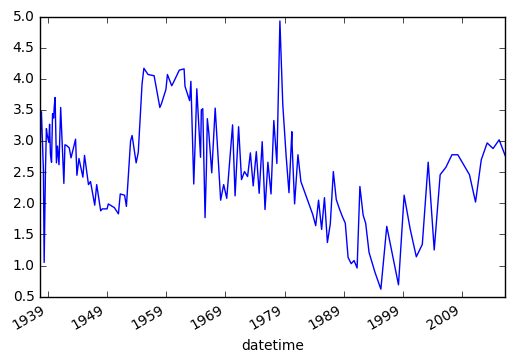

In [5]:
clean_wl = USGS.cleanGWL(wldata)
onesite = clean_wl[(clean_wl['value']>0)&(clean_wl.index.get_level_values('site_no') == '400219111393701')]
onesite.reset_index(inplace=True)
onesite.set_index('datetime',inplace=True)
onesite['value'].plot()

In [6]:
siteinfo['Elev'] = siteinfo[['dec_long_va','dec_lat_va']].apply(lambda x: wa.get_elev(x),1)

In [7]:
df = USGS.avg_wl()

c:\users\paulinkenbrandt\documents\github\env\lib\site-packages\pandas\core\indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\paulinkenbrandt\documents\github\env\lib\site-packages\pandas\core\indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(30L, 47L)

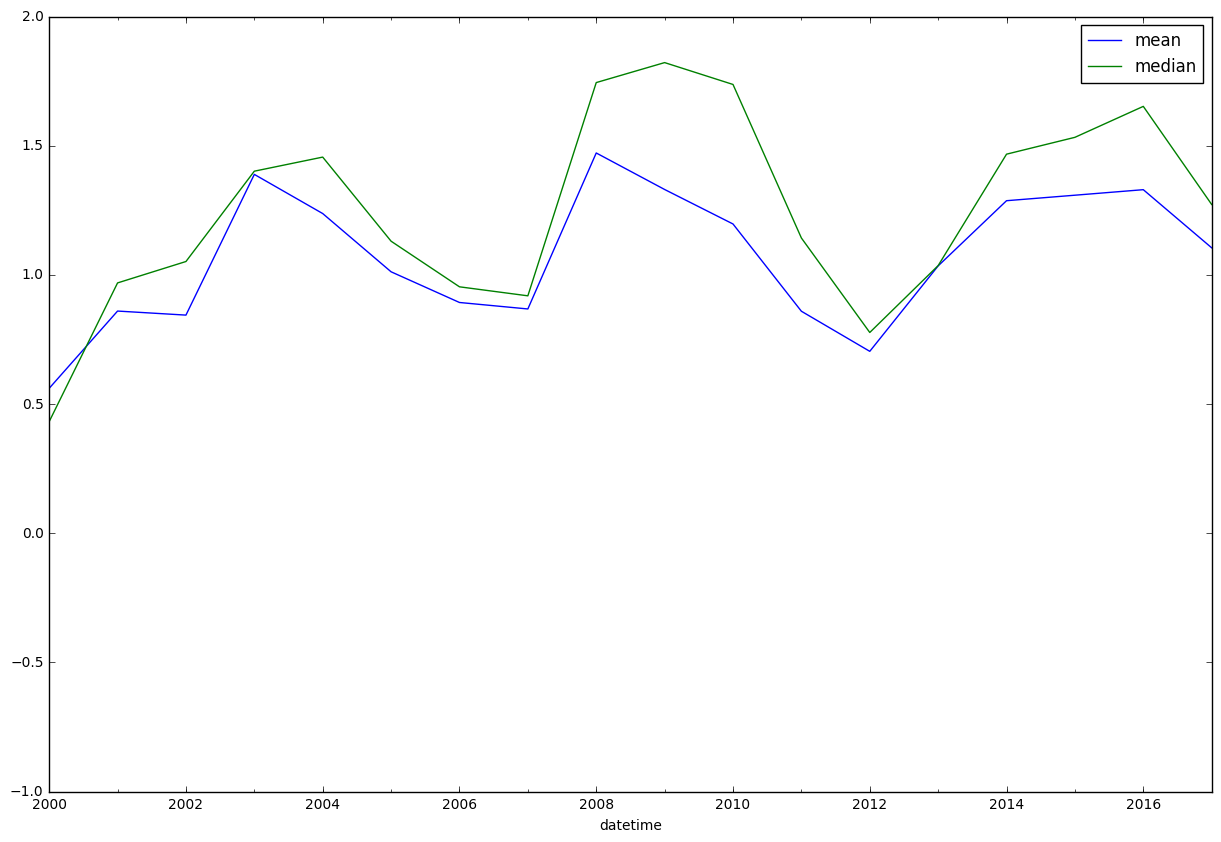

In [8]:
rcParams['figure.figsize'] = 15, 10
df[['mean','median']].plot()
plt.xlim('1/1/2000','1/1/2017')